# Totorial on the Simulation of the DNA Environment

Discover how to model DNA excited-state relaxation and environmental interactions using dephasing and thermalization models from Quantum Biology.
This notebook explores various methods for incorporating DNA environment effects and exciton relaxation in the `qDNA` package. Key topics include:

* **Dephasing**: Analyzing the impact of environmental noise on quantum states.
* **Thermalizing**: Modeling the system's approach to thermal equilibrium.
* **Trace Distance to Equilibrium**: Measuring how close the system is to its equilibrium state.
  
Through these examples, the notebook demonstrates advanced techniques for simulating and analyzing DNA-related quantum phenomena.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/dehe1011/QuantumDNA-notebooks/blob/main/tutorials/3_Environment_Simulation.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

# Flags
save = False          # Set to True to enable saving results (currently unused in this script)
verbose = False       # Set to True to enable detailed logging

## Setup

In [2]:
import os
import importlib.util

# Check if the 'qDNA' package is already installed
qDNA_installed = importlib.util.find_spec('qDNA') is not None

if qDNA_installed:
    if verbose:
        print("Package 'qDNA' is already installed.")
        # Optional: Uncomment the next line to display qDNA package information
        # %pip show qDNA
else:
    # Install 'qDNA' package if not installed
    %pip install qDNA
    if verbose:
        print("Successfully installed the 'qDNA' package.")

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from qDNA import ROOT_DIR as ROOT_DIR_QDNA

# Use the current working directory as the root
ROOT_DIR = os.getcwd()

# Define directories for data and figures
DATA_DIR = os.path.join(ROOT_DIR, "data", "my_tb_params")
FIG_DIR = os.path.join(ROOT_DIR_QDNA, "qDNA", "data", "figures_tutorials")

# Ensure the directories exist (create them if they don't already exist)
os.makedirs(DATA_DIR, exist_ok=True)

SAVE_DIR = os.path.join(os.getcwd(), "my_figures")  # Directory for plots 
if save:
    os.makedirs(os.path.join(os.getcwd(), SAVE_DIR), exist_ok=True)

if verbose:
    # Print the status of the directories for debugging purposes
    print(f"Data directory: '{DATA_DIR}' is ready.")
    print(f"Figures directory: '{FIG_DIR}' is ready.")
    print(f"Save directory: '{SAVE_DIR}' is ready.")

In [4]:
from qDNA import DNA_Seq, TB_Ham, Lindblad_Diss, ME_Solver

upper_strand = 'G'
lower_strand = 'C'
tb_model_name = 'ELM'
kwargs = dict(uniform_relaxation=False, relax_rates={'C':3, 'G':4})

dna_seq = DNA_Seq(upper_strand, tb_model_name, lower_strand=lower_strand)
tb_ham = TB_Ham(dna_seq, **kwargs)
lindblad_diss = Lindblad_Diss(tb_ham, **kwargs)
me_solver = ME_Solver(tb_ham, lindblad_diss, **kwargs)

In [5]:
from qDNA import get_deph_eq_state, get_therm_eq_state, get_pop_particle, plot_pop, plot_coh, get_reduced_dm

def my_plot_pop(me_solver):
    if me_solver.lindblad_diss.loc_deph_rate:
        lindblad_type = "local dephasing"
    elif me_solver.lindblad_diss.glob_deph_rate:
        lindblad_type = "global dephasing"
    elif me_solver.lindblad_diss.loc_therm:
        lindblad_type = "local thermalizing"
    elif me_solver.lindblad_diss.glob_therm:
        lindblad_type = "global thermalizing"
        
    if lindblad_type in ["local dephasing", "global dephasing"]:
        eq_state = get_deph_eq_state(me_solver)
    if lindblad_type in ["local thermalizing", "global thermalizing"]:
        eq_state = get_therm_eq_state(me_solver)
        
    print(f"Number of {lindblad_type} operators: {me_solver.lindblad_diss.num_c_ops}")
    print("--------------------------------")

    pop_particle_dict = {}
    for particle in me_solver.tb_ham.particles:
        pop_particle_op = get_pop_particle(me_solver.tb_ham.tb_basis, particle, tb_site)
        pop_particle = np.trace(eq_state @ pop_particle_op)
        pop_particle_dict[particle] = pop_particle
        print(f"Equilibium Population {particle.capitalize()}: {round(pop_particle, 3)}")

    fig, ax = plt.subplots()
    plot_pop(ax, tb_site, me_solver)
    for particle in me_solver.tb_ham.particles:
        ax.axhline(y=pop_particle_dict[particle], color='k', linestyle='--', alpha=0.5)

    return fig, ax

def my_plot_coh(me_solver):
    if me_solver.lindblad_diss.loc_deph_rate:
        lindblad_type = "local dephasing"
    elif me_solver.lindblad_diss.glob_deph_rate:
        lindblad_type = "global dephasing"
    elif me_solver.lindblad_diss.loc_therm:
        lindblad_type = "local thermalizing"
    elif me_solver.lindblad_diss.glob_therm:
        lindblad_type = "global thermalizing"
        
    if lindblad_type in ["local dephasing", "global dephasing"]:
        eq_state = get_deph_eq_state(me_solver)
    if lindblad_type in ["local thermalizing", "global thermalizing"]:
        eq_state = get_therm_eq_state(me_solver)
        
    print(f"Number of local dephasing operators: {me_solver.lindblad_diss.num_c_ops}")
    print("--------------------------------")
    
    coh_particle_dict = {}
    for particle in me_solver.tb_ham.particles:
        reduced_dm = get_reduced_dm(eq_state, particle, me_solver.tb_ham.tb_basis)
        coh_particle = np.sum(np.abs(reduced_dm)).real - np.sum(np.diag(reduced_dm)).real
        coh_particle_dict[particle] = coh_particle
        print(f"Equilibium Coherence {particle.capitalize()}: {round(coh_particle, 3)}")
    
    fig, ax = plt.subplots()
    plot_coh(ax, me_solver)
    for particle in me_solver.tb_ham.particles:
        ax.axhline(y=coh_particle_dict[particle], color='k', linestyle='--', alpha=0.5)

    return fig, ax

## Local Dephasing

Number of local dephasing operators: 4
--------------------------------
Equilibium Population Electron: 0.5
Equilibium Population Hole: 0.5
Equilibium Population Exciton: 0.25


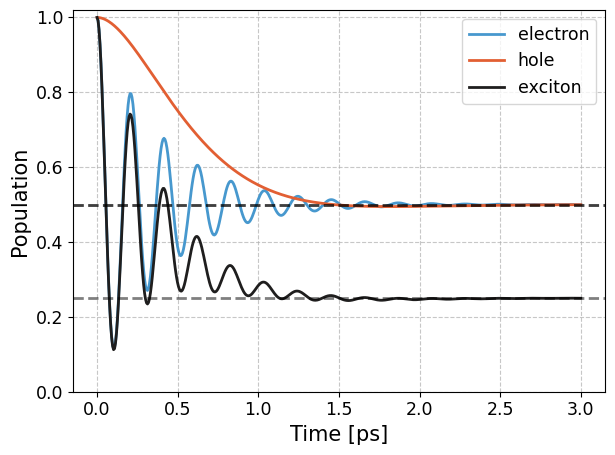

In [6]:
from qDNA import get_me_solver, save_figure 

kwargs = dict(description='2P', loc_deph_rate=5)
upper_strand, tb_model_name = 'GC', 'WM'
tb_site = '(0, 0)'

me_solver = get_me_solver(upper_strand, tb_model_name, **kwargs)
fig, ax = my_plot_pop(me_solver)

if save:
    save_figure(fig, 'loc_deph_pop', SAVE_DIR, extension='pdf')
plt.show()

Number of local dephasing operators: 8
--------------------------------
Equilibium Coherence Electron: 0.0
Equilibium Coherence Hole: 0.0
Equilibium Coherence Exciton: 0.0


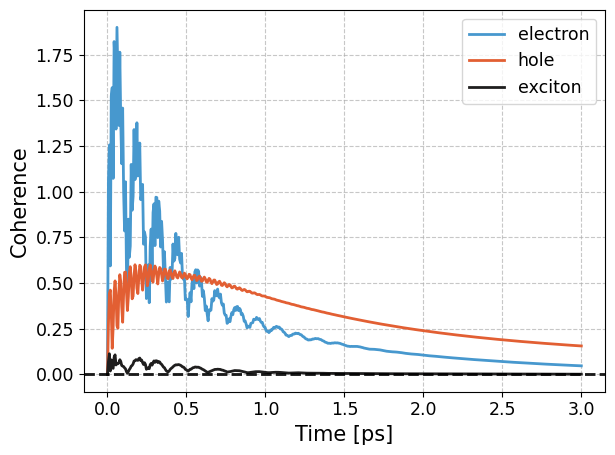

In [7]:
# since the equilibrium state does not contain off-diagonal elements the coherence relaxes to zero

from qDNA import get_me_solver, save_figure

kwargs=dict(description='2P', loc_deph_rate=5)
upper_strand, tb_model_name= 'GC', 'ELM'

me_solver = get_me_solver(upper_strand, tb_model_name, **kwargs)
fig, ax = my_plot_coh(me_solver)

if save:
    save_figure(fig, 'loc_deph_coh', SAVE_DIR, extension='pdf')
plt.show()

Equilibium Population Electron at site (0, 0): 0.25
Equilibium Population Electron at site (0, 1): 0.25
Equilibium Population Electron at site (1, 0): 0.25
Equilibium Population Electron at site (1, 1): 0.25


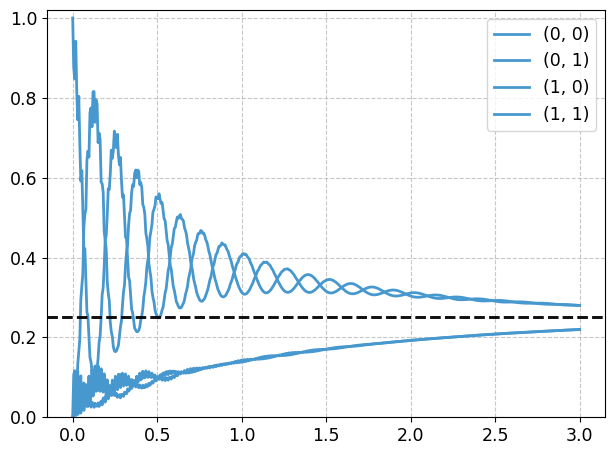

In [8]:
from qDNA import get_me_solver, plot_pop, get_deph_eq_state, get_pop_particle

kwargs = dict(description='2P', particles=['electron'], loc_deph_rate=4)
upper_strand, tb_model_name = 'GC', 'ELM'

me_solver = get_me_solver(upper_strand, tb_model_name, **kwargs)
eq_state = get_deph_eq_state(me_solver)
tb_basis = me_solver.tb_ham.tb_basis
particle = me_solver.tb_ham.particles[0]

pop_particle_dict = {}
for tb_site in tb_basis:
    pop_particle_op = get_pop_particle(tb_basis, particle, tb_site)
    pop_particle = np.trace(eq_state @ pop_particle_op)
    pop_particle_dict[tb_site] = pop_particle
    print(f"Equilibium Population {particle.capitalize()} at site {tb_site}: {round(pop_particle, 3)}")

fig, ax = plt.subplots()
for tb_site in tb_basis:
    plot_pop(ax, tb_site, me_solver, add_legend=False)
ax.legend(tb_basis)
for tb_site in tb_basis:
    ax.axhline(y=pop_particle_dict[tb_site], color='k', linestyle='--', alpha=0.5)

if save:
    save_figure(fig, f'loc_deph_pop_{particle}', SAVE_DIR, extension='pdf')
plt.show()

## Global Dephasing

Number of global dephasing operators: 4
--------------------------------
Equilibium Population Electron: 0.5
Equilibium Population Hole: 0.5
Equilibium Population Exciton: 0.25


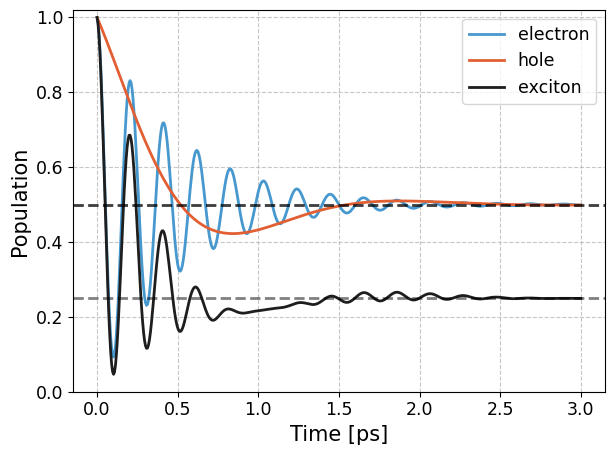

In [9]:
from qDNA import get_me_solver, save_figure

kwargs = dict(description='2P', glob_deph_rate=2)
upper_strand, tb_model_name = 'GC', 'WM'
tb_site = '(0, 0)'

me_solver = get_me_solver(upper_strand, tb_model_name, **kwargs)
fig, ax = my_plot_pop(me_solver)

if save:
    save_figure(fig, 'glob_deph_pop', SAVE_DIR, extension='pdf')
plt.show()

Number of local dephasing operators: 16
--------------------------------
Equilibium Coherence Electron: 0.527
Equilibium Coherence Hole: 0.23
Equilibium Coherence Exciton: 0.017


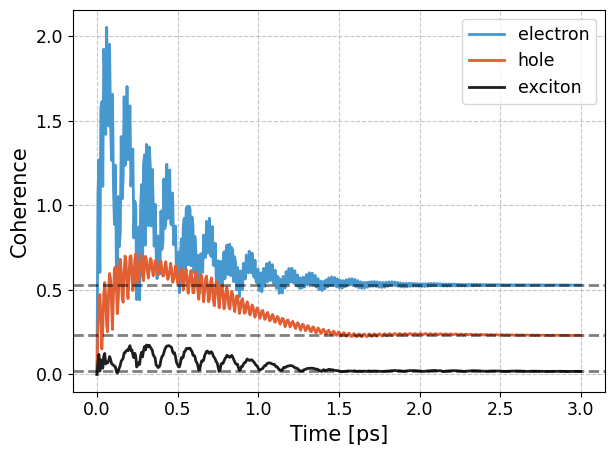

In [10]:
# the equilibirum state contains off-diagonal elements indicating the coherences even in the equilibrium.

from qDNA import get_me_solver, save_figure

kwargs=dict(description='2P', glob_deph_rate=2)
upper_strand, tb_model_name= 'GC', 'ELM'

me_solver = get_me_solver(upper_strand, tb_model_name, **kwargs)
fig, ax = my_plot_coh(me_solver)

if save:
    save_figure(fig, 'glob_deph_coh', SAVE_DIR, extension='pdf')
plt.show()

## Local Thermalizing

Number of local thermalizing operators: 52
--------------------------------
Equilibium Population Electron: 0.5
Equilibium Population Hole: 0.5
Equilibium Population Exciton: 0.25


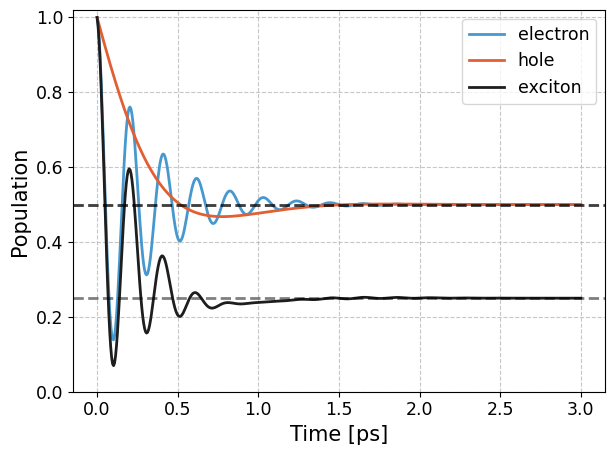

In [11]:
from qDNA import get_me_solver, save_figure

kwargs = dict(description='2P', loc_therm=True)
upper_strand, tb_model_name = 'GC', 'WM'
tb_site = '(0, 0)'

me_solver = get_me_solver(upper_strand, tb_model_name, **kwargs)
fig, ax = my_plot_pop(me_solver)

if save:
    save_figure(fig, 'loc_deph_pop', SAVE_DIR, extension='pdf')
plt.show()

Number of local dephasing operators: 3728
--------------------------------
Equilibium Coherence Electron: 0.963
Equilibium Coherence Hole: 0.384
Equilibium Coherence Exciton: 0.027


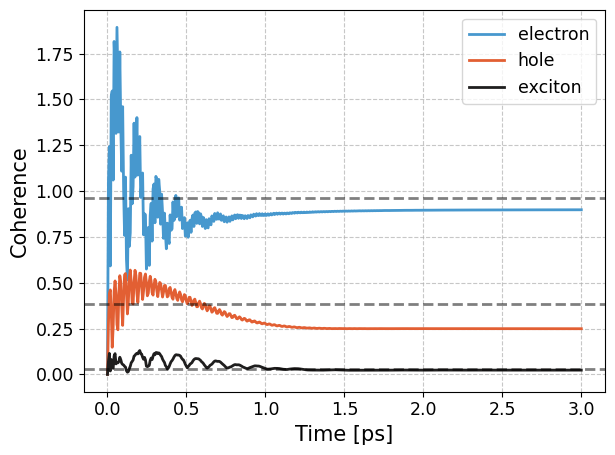

In [12]:
from qDNA import get_me_solver, save_figure

kwargs=dict(description='2P', loc_therm=True)
upper_strand, tb_model_name= 'GC', 'ELM'

me_solver = get_me_solver(upper_strand, tb_model_name, **kwargs)
fig, ax = my_plot_coh(me_solver)

if save:
    save_figure(fig, 'loc_therm_coh', SAVE_DIR, extension='pdf')
plt.show()

## Global Thermalizing

Number of global thermalizing operators: 12
--------------------------------
Equilibium Population Electron: 0.5
Equilibium Population Hole: 0.5
Equilibium Population Exciton: 0.25


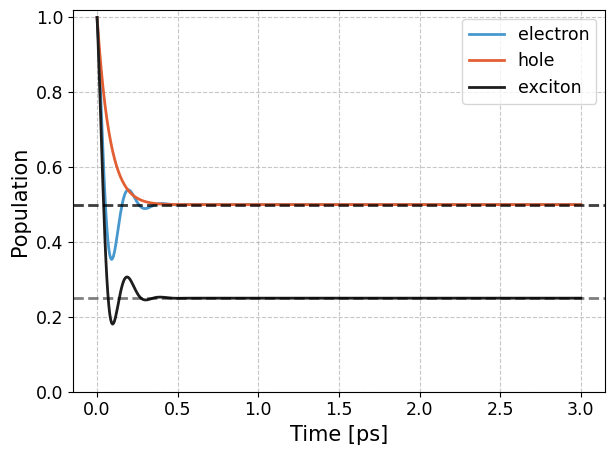

In [13]:
from qDNA import get_me_solver, save_figure

kwargs = dict(description='2P', glob_therm=True)
upper_strand, tb_model_name = 'GC', 'WM'
tb_site = '(0, 0)'

me_solver = get_me_solver(upper_strand, tb_model_name, **kwargs)
fig, ax = my_plot_pop(me_solver)

if save:
    save_figure(fig, 'loc_deph_pop', SAVE_DIR, extension='pdf')
plt.show()

Number of local dephasing operators: 240
--------------------------------
Equilibium Coherence Electron: 0.963
Equilibium Coherence Hole: 0.384
Equilibium Coherence Exciton: 0.027


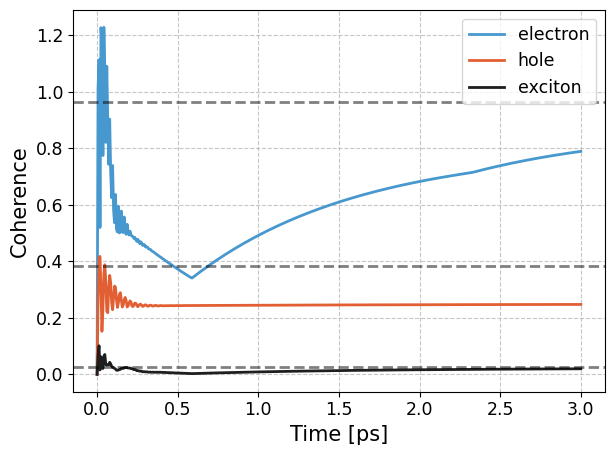

In [14]:
from qDNA import get_me_solver, save_figure

kwargs=dict(description='2P', glob_therm=True)
upper_strand, tb_model_name= 'GC', 'ELM'

me_solver = get_me_solver(upper_strand, tb_model_name, **kwargs)
fig, ax = my_plot_coh(me_solver)

if save:
    save_figure(fig, 'glob_therm_coh', SAVE_DIR, extension='pdf')
plt.show()

## Trace distance to the Equilibium

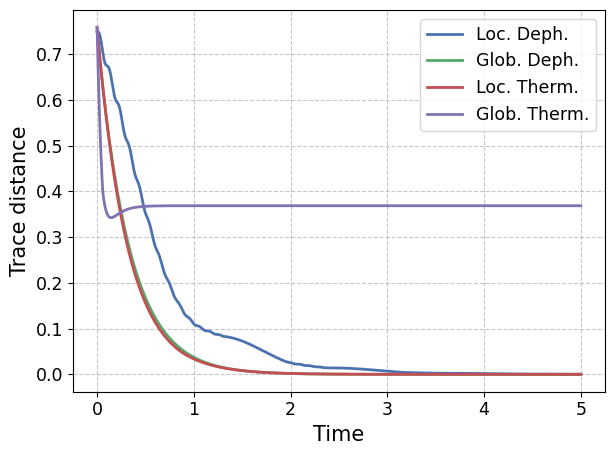

In [16]:
from qDNA import calc_trace_distance

upper_strand, tb_model_name= 'GC', 'WM'

kwargs_loc_deph = dict(description='2P', loc_deph_rate=3, relaxation=False, t_end=5)
kwargs_glob_deph = dict(description='2P', glob_deph_rate=3, relaxation=False, t_end=5)
kwargs_loc_therm = dict(description='2P', loc_therm=True, relaxation=False, t_end=5)
kwargs_glob_therm = dict(description='2P', glob_therm=True, relaxation=False, t_end=5)
kwargs_list = [kwargs_loc_deph, kwargs_glob_deph, kwargs_loc_therm, kwargs_glob_therm]

trace_distance_list = []
for kwargs in kwargs_list:
    me_solver = get_me_solver(upper_strand, tb_model_name, **kwargs)
    if me_solver.lindblad_diss.loc_deph_rate or me_solver.lindblad_diss.glob_deph_rate:
        eq_state = get_deph_eq_state(me_solver)
    if me_solver.lindblad_diss.loc_therm or me_solver.lindblad_diss.glob_therm:
        eq_state = get_therm_eq_state(me_solver)
    dms = me_solver.get_result()
    trace_distance = [ calc_trace_distance(dm.full(), eq_state) for dm in dms ]
    trace_distance_list.append(trace_distance)

fig, ax = plt.subplots()
for trace_distance in trace_distance_list:
    ax.plot(me_solver.times, trace_distance)
ax.legend(['Loc. Deph.', 'Glob. Deph.', 'Loc. Therm.', 'Glob. Therm.'])
ax.set_ylabel('Trace distance')
ax.set_xlabel('Time')
plt.show()